In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

train = pd.read_csv("./dataSet/train.csv")
test_orj  = pd.read_csv("./dataSet/test.csv")

print("Training set has {0[0]} rows and {0[1]} columns".format(train.shape))
print("Test set has {0[0]} rows and {0[1]} columns".format(test_orj.shape))

Using TensorFlow backend.


Training set has 42000 rows and 785 columns
Test set has 28000 rows and 784 columns


In [2]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

<class 'pandas.core.frame.DataFrame'>


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000860,0.000459,0.000231,0.000079,0.000068,0.000011,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024756,0.018172,0.012841,0.006901,0.007429,0.001625,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996078,0.996078,0.992157,0.992157,0.996078,0.243137,0.0,0.0,0.0,0.0


/home/hongfu1220/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


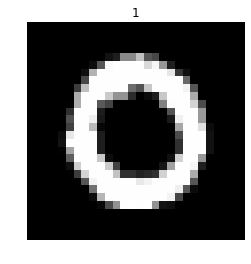

In [3]:
# plot some samples
print(type(X_train))
X_train = X_train / 255.0
display(X_train.describe())
img = X_train.iloc[1].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

In [ ]:


# Easy model start from here!!!!!!!!!!!!!!!



In [ ]:
# Declare data set, optimizers and callback function for easy model
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop("label",axis = 1) 

X_train = X_train / 255.0
test = test_orj.copy() / 255.0

# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

# Select optimizer
lr = 1e-4
sgd = keras.optimizers.SGD(lr=lr, momentum=0.9)
rms_prop = keras.optimizers.RMSprop(lr=lr)
# adam = tf.contrib.optimizer_v2.AdamOptimizer
# adam = keras.optimizers.adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
# adamax = keras.optimizers.Adamax(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

# Declare callback functions
# Reduce the learning rate when gradient dicrease
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

# Build tensorboard
tensorboard = TensorBoard(
    log_dir='./Graph',
    histogram_freq=0,
    write_graph=True,
    write_images=True
)

# Saving model callback function
def checkpoint(sequential):
    checkpoint_path = './keras_model/' + ('sequential' if sequential else 'functional') + '2.ckpt'
    check = ModelCheckpoint(
        checkpoint_path,
        save_weights_only=True,
        verbose=1,
    )
    return check

x_train shape (37800, 784)
x_val shape (4200, 784)
y_train shape (37800, 10)
y_test shape (4200, 10)


In [ ]:
# Keras funtional model
from keras.layers import Input, Dense
from keras.models import Model

batch_size = 128
num_classes = 10
epochs = 25

inputs = Input(shape=(784,))

x = Dense(512, activation='relu')(inputs)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy',
    optimizer=rms_prop,
    metrics=['accuracy'])

history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, Y_val),
    callbacks=[learning_rate_reduction, tensorboard, checkpoint(False)])
score = model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model = model
model.summary()

result = model.predict(test, verbose=1)

In [ ]:
# Save result to csv

# result = model.predict(test, verbose=1)
result = np.argmax(result, axis=1)

image_id = []
for i in range(len(result)):
    image_id.append(i + 1)
d = {
    'ImageId': image_id,
    'Label': result,
}
result = pd.DataFrame(d)
result.to_csv('./result', index=False)

print('Save result to csv')

In [ ]:
# Tensorboard validation and train graph
import tensorflow as tf

writer_1 = tf.summary.FileWriter("./4logs/training")
writer_2 = tf.summary.FileWriter("./4logs/validation")

log_var = tf.Variable(0.0)
tf.summary.scalar("loss", log_var)
write_loss = tf.summary.merge_all()

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

i = 0
for train, validate in zip(history.history['loss'], history.history['val_loss']):
    summary = session.run(write_loss, {log_var: train})
    writer_1.add_summary(summary, i)
    writer_1.flush()

    summary = session.run(write_loss, {log_var: validate})
    writer_2.add_summary(summary, i)
    writer_2.flush()
    i += 1